In [640]:
from readability.readability import Document
import operator
from itertools import takewhile, tee, izip
import networkx
%matplotlib inline

import mechanize
import nltk
from bs4 import BeautifulSoup
from html2text import html2text 
import re
import json
import urllib2
import requests
import pandas as pd
import re
from os import walk
from os import path
import yaml
from collections import OrderedDict, defaultdict
import sys
import string
from collections import defaultdict
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer #--for stemming
from simhash import Simhash, SimhashIndex
from hashlib import md5, sha1
import unicodedata
import numpy as np
from nltk.stem.porter import *
import itertools, nltk, string
import random
import collections, math, nltk, re
import matplotlib.pyplot as plt
import numpy as np
import re
import warnings
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from os import walk
from os import path
from pprint import pprint
from scipy.stats import sem # standard error of mean
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score, train_test_split, StratifiedShuffleSplit
from sklearn.feature_selection import SelectPercentile, SelectKBest, chi2, f_classif, f_regression
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, _predict_binary
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sys import maxint
from time import time
from scipy.cluster.vq import whiten
import pdb
from sklearn.learning_curve import learning_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, precision_score,recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import average_precision_score
from scipy import interp
import urllib2
import requests

# HTML parsing

In [444]:
def clean_html(html):
    """
    Copied from NLTK package.
    Remove HTML markup from the given string.

    :param html: the HTML string to be cleaned
    :type html: str
    :rtype: str
    """
    # First we remove inline JavaScript/CSS:
    cleaned = re.sub(r"(?is)<(script|style).*?>.*?(</\1>)", "", html.strip())
    # Then we remove html comments. This has to be done before removing regular
    # tags since comments can contain '>' characters.
    cleaned = re.sub(r"(?s)<!--(.*?)-->[\n]?", "", cleaned)
    # Next we can remove the remaining tags:
    cleaned = re.sub(r"(?s)<.*?>", " ", cleaned)
    # Finally, we deal with whitespace
    cleaned = re.sub(r"&nbsp;", " ", cleaned)
    cleaned = re.sub(r"  ", " ", cleaned)
    cleaned = re.sub(r"  ", " ", cleaned)
    return cleaned.strip()

def extract_text_html(url):
    '''
    Function to get the web page content and cleans it using readability package
    '''
    try:    
        opener = urllib2.build_opener()
        opener.addheaders = [('User-agent', 'Mozilla/5.0')]
        response = opener.open(url)
        html_contents = response.read()
        readable_article = Document(html_contents).summary()
        readable_title = Document(html_contents).short_title()
        cleanhtml = clean_html(readable_article)
        text = html2text(cleanhtml)
        return readable_title, text  
    
    except urllib2.HTTPError, error:
        print error.read()
        sys.exit(1)
    except requests.exceptions.RequestException as e:
        # catastrophic error.
        print e
        sys.exit(1)  

# Candidate Identification

In [612]:
def token_to_pos(ch):
    tokens = nltk.word_tokenize(ch)
    return [p[1] for p in nltk.pos_tag(tokens)]

def is_good_POS(candidate):

    tagged_sents = token_to_pos(candidate)
    for pos in tagged_sents:
        if pos == 'NN' or pos == 'NNS':
            return True
    return False

def is_number(candidate):
    for s in nltk.word_tokenize(candidate):
        try:
            float(s) if '.' in s else int(s)
        except ValueError:
            return False
    return True


def load_stop_words(stop_word_file):
    """
    Utility function to load stop words from a file and return as a list of words
    @param stop_word_file Path and file name of a file containing stop words.
    @return list A list of stop words.
    """
    stop_words = []
    for line in open(stop_word_file):
        if line.strip()[0:1] != "#":
            for word in line.split():  # in case more than one per line
                stop_words.append(word)
    return stop_words


def split_sentences(text):
    """
    returns a list of sentences.
    @param text The text that must be split in to sentences.
    """
    sentence_delimiters = re.compile(u'[.!?,;:\t\\\\"\\(\\)\\\'\u2019\u2013\n]|\\s\\-\\s')
    sentences = sentence_delimiters.split(text)
    return sentences


def build_stop_word_regex(stop_word_file_path):
    stop_word_list = load_stop_words(stop_word_file_path)
    stop_word_regex_list = []
    for word in stop_word_list:
        word_regex = r'\b' + word + r'(?![\w-])'  # added look ahead for hyphen
        stop_word_regex_list.append(word_regex)
    stop_word_pattern = re.compile('|'.join(stop_word_regex_list), re.IGNORECASE)
    return stop_word_pattern


def generate_candidate_keywords(sentence_list, stopword_pattern):
    phrase_list = []
    phrase_list2 = []
    punct = set(string.punctuation)
    for s in sentence_list:
        tmp = re.sub(stopword_pattern, '|', s.strip())
        phrases = tmp.split("|")
        for phrase in phrases:
            phrase = phrase.strip().lower()
            if phrase != "":
                noPunct = removePunctuations(phrase)
                phrase_list.append(noPunct)
    
    for phrase in phrase_list:
        splitted = phrase.split()
        if is_number(phrase) is False:
            if (len(splitted) > 3):  #if the length of the phrase is > 3, split into 2-grams
                for i in range (0,len(splitted)-2):
                    cand = phrase.split()[i]+" " +phrase.split()[i+1]+" "+phrase.split()[i+2]
                    if is_good_POS(cand):
                        phrase_list2.append(cand)
            else:
                if is_good_POS(phrase):
                    phrase_list2.append(phrase)
    
    return phrase_list2



In [613]:
def removePunctuations (phrase):
    # define punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in phrase:
        if char not in punctuations:
            no_punct = no_punct + char

    return no_punct
  

In [644]:
def separate_words(text, min_word_return_size):
    """
    Utility function to return a list of all words that are have a length greater than a specified number of characters.
    @param text The text that must be split in to words.
    @param min_word_return_size The minimum no of characters a word must have to be included.
    """
    splitter = re.compile('[^a-zA-Z0-9_\\+\\-/]')
    words = []
    for single_word in splitter.split(text):
        current_word = single_word.strip().lower()
        #leave numbers in phrase, but don't count as words, since they tend to invalidate scores of their phrases
        if len(current_word) > min_word_return_size and current_word != '' and not is_number(current_word):
            words.append(current_word)
    return words


# RAKE

In [491]:
def calculate_word_scores(phraseList):
    word_frequency = {}
    word_degree = {}
    for phrase in phraseList:
        word_list = separate_words(phrase, 0)
        word_list_length = len(word_list)
        word_list_degree = word_list_length - 1
        #if word_list_degree > 3: word_list_degree = 3 #exp.
        for word in word_list:
            word_frequency.setdefault(word, 0)
            word_frequency[word] += 1
            word_degree.setdefault(word, 0)
            word_degree[word] += word_list_degree  #orig.
            #word_degree[word] += 1/(word_list_length*1.0) #exp.
    for item in word_frequency:
        word_degree[item] = word_degree[item] + word_frequency[item]

    # Calculate Word scores = deg(w)/frew(w)
    word_score = {}
    for item in word_frequency:
        word_score.setdefault(item, 0)
        word_score[item] = word_degree[item] / (word_frequency[item] * 1.0)  #orig.
    #word_score[item] = word_frequency[item]/(word_degree[item] * 1.0) #exp.
    return word_score


def generate_candidate_keyword_scores(phrase_list, word_score):
    keyword_candidates = {}
    for phrase in phrase_list:
        keyword_candidates.setdefault(phrase, 0)
        word_list = separate_words(phrase, 0)
        candidate_score = 0
        for word in word_list:
            candidate_score += word_score[word]
        keyword_candidates[phrase] = candidate_score
    return keyword_candidates


class Rake(object):
       def run(self, phrase_list):

        word_scores = calculate_word_scores(phrase_list)

        keyword_candidates = generate_candidate_keyword_scores(phrase_list, word_scores)

        sorted_keywords = sorted(keyword_candidates.iteritems(), key=operator.itemgetter(1), reverse=True)
        return sorted_keywords

# TextRank Algorithm-- builds graph of connected words

In [566]:
def extract_candidate_words(text, good_tags=set(['JJ','JJR','JJS','NN','NNP','NNS','NNPS'])):
    import itertools, nltk, string

    # exclude candidates that are stop words or entirely punctuation
    punct = set(string.punctuation)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    # tokenize and POS-tag words
    tagged_words = itertools.chain.from_iterable(nltk.pos_tag_sents(nltk.word_tokenize(sent)
                                                                    for sent in nltk.sent_tokenize(text)))
    # filter on certain POS tags and lowercase all words
    candidates = [word.lower() for word, tag in tagged_words
                  if tag in good_tags and word.lower() not in stop_words
                  and not all(char in punct for char in word)]

    return candidates

def score_keyphrases_by_textrank(text, n_keywords=0.05):
       
    # tokenize for all words
    words = [word.lower()
             for sent in nltk.sent_tokenize(text)
             for word in nltk.word_tokenize(sent)]
    candidates = extract_candidate_words(text)
    # build graph, each node is a unique candidate
    graph = networkx.Graph()
    graph.add_nodes_from(set(candidates))
    # iterate over word-pairs, add unweighted edges into graph
    def pairwise(iterable):
        """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
        a, b = tee(iterable)
        next(b, None)
        return izip(a, b)
    for w1, w2 in pairwise(candidates):
        if w2:
            graph.add_edge(*sorted([w1, w2]))
    # score nodes using default pagerank algorithm, sort by score, keep top n_keywords
    ranks = networkx.pagerank(graph)
    if 0 < n_keywords < 1:
        n_keywords = int(round(len(candidates) * n_keywords))
    word_ranks = {word_rank[0]: word_rank[1]
                  for word_rank in sorted(ranks.iteritems(), key=lambda x: x[1], reverse=True)[:n_keywords]}
    keywords = set(word_ranks.keys())
    # merge keywords into keyphrases
    keyphrases = {}
    j = 0
    for i, word in enumerate(words):
        if i < j:
            continue
        if word in keywords:
            kp_words = list(takewhile(lambda x: x in keywords, words[i:i+10]))
            avg_pagerank = sum(word_ranks[w] for w in kp_words) / float(len(kp_words))
            keyphrases[' '.join(kp_words)] = avg_pagerank
            # counter as hackish way to ensure merged keyphrases are non-overlapping
            j = i + len(kp_words)
    
    return sorted(keyphrases.iteritems(), key=lambda x: x[1], reverse=True)

class TextRank(object):
    def run(self,text):
        keywords = score_keyphrases_by_textrank(text, 0.4 )
        return keywords

# Supervised approach

# 1. Generating training and test feature matrix

In [8]:
def get_file_dir_list(dir):
    '''
    Get a list of directories and files. Used to get the corpora.
    Returns
    -------
    dir_list: list of directory names to serve as class labels.
    file_list: list of files in corpus.
    '''

    file_list = []
    dir_list = []
    for (dirpath, dirname, files) in walk(dir):
        if files:
            dir_list.append(path.split(dirpath)[1])
            file_list.append(map(lambda x: path.join(dirpath, x), files))
    return dir_list, file_list

In [9]:
def load_stop_words(stop_word_file):
    """
    function to load stop words from a file and return as a list of words
    @param stop_word_file Path and file name of a file containing stop words.
    @return list A list of stop words.
    """
    stop_words = []
    for line in open(stop_word_file):
        if line.strip()[0:1] != "#":
            for word in line.split():  # in case more than one per line
                stop_words.append(word)
    return stop_words

def tokenize(str):
    tokens = nltk.word_tokenize(str)
    return tokens


def generate_negative_keywords(word_tokens,  candidates, title):
    phrase_list = []
    #load Stop words, concatenate with candidates and filter against
    stop_words_path = "SmartStoplist.txt"
    stopWords = load_stop_words(stop_words_path)
    notNegList = stopWords + candidates + tokenize(title)
    notNegSet = set(notNegList)
        
    # define punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

    negatives = []
    # remove punctuation from the string
    for word in word_tokens:
        if word not in notNegSet: 
            no_punct = ""
            for char in word:
                if char not in punctuations:
                    no_punct = no_punct + char
        
            if no_punct != "" and len(no_punct) >= 3:
                negatives.append(no_punct)
    return negatives

In [414]:
def extract_candidate_features(candidates, doc_text,  doc_title): #doc_excerpt in abstract or introductory paragraph
    
    
    candidate_scores = collections.OrderedDict()
    
    # get word counts for document
    doc_word_counts = collections.Counter(word.lower()
                                          for sent in nltk.sent_tokenize(doc_text)
                                          for word in nltk.word_tokenize(sent))
    
    features = collections.OrderedDict()
    
    
    for candidate in candidates:
        if candidate != "" and len(candidate) >2:
            pattern = re.compile(re.escape(candidate), re.IGNORECASE)
            # frequency-based
            # number of times candidate appears in document
            cand_doc_count = len(pattern.findall(doc_text))
            doc_text_length = float(len(doc_text))
            cand_doc_count_normalized =cand_doc_count /  doc_text_length
            if not cand_doc_count:
                #print '**WARNING:', candidate, 'not found!'
                #print doc_text
                continue

            # statistical
            candidate_words = candidate.split()
            max_word_length = max(len(w) for w in candidate_words)
            term_length = len(candidate_words)
            # get frequencies for term and constituent words
            sum_doc_word_counts = float(sum(doc_word_counts[w] for w in candidate_words))
            try:
                # lexical cohesion doesn't make sense for 1-word terms
                if term_length == 1:
                    lexical_cohesion = 0.0
                else:
                    lexical_cohesion = term_length * (1 + math.log(cand_doc_count, 10)) * cand_doc_count / sum_doc_word_counts
            except (ValueError, ZeroDivisionError) as e:
                lexical_cohesion = 0.0

            # positional
            # found in title
            in_title_sum=0
            for w in candidate_words:
                in_title_sum = in_title_sum + (1 if re.search(w, doc_title) else 0)

            # first/last position, difference between them (spread)
            first_match = pattern.search(doc_text)
            abs_first_occurrence = first_match.start() / doc_text_length
            if cand_doc_count == 1:
                spread = 0.0
                abs_last_occurrence = abs_first_occurrence
            else:
                for last_match in pattern.finditer(doc_text):
                    pass
                abs_last_occurrence = last_match.start() / doc_text_length
                spread = abs_last_occurrence - abs_first_occurrence

            candidate_scores[candidate] = [ cand_doc_count_normalized, term_length,  max_word_length, spread,  
                                           lexical_cohesion, in_title_sum, abs_first_occurrence, abs_last_occurrence]

    return candidate_scores

In [433]:
def load_features_from_corpus( file_list):
    '''
    Parse each text file and generate its features.
    '''

    X = []
    Y = []
    count = 0
    totalwords = 0
    for index, files in enumerate(file_list):
       
        for f in files:
            if f.endswith('-justTitle.txt'):
                #count = count +1
                #if count == 100:
                #    break
                titleFile = f
                textFile = f.split('-justTitle.txt')[0]+".txt"
                candidateFile = f.split('-justTitle.txt')[0]+".key"
            
                text = open(textFile).read().decode('utf-8')
                title = open(titleFile).read().decode('utf-8')
                candidates= open(candidateFile).read().decode('utf-8').split('\n')
                if(len(candidates)>=1):
                    #generate features for candidates
                    
                    candidate_score = extract_candidate_features(candidates, text, title)

                    #get some negative words, and make sure they are not in the candidates
                    nonCandidates = generate_negative_keywords (tokenize(text),candidates, title) 
                    negative=[]
                    for i in range(0,len(candidates)):
                        negative.append( random.choice(nonCandidates))

                    #generate features for the negative examples
                    negative_score = extract_candidate_features(negative, text, title)

                    #generate matrix
                    instance_X = np.concatenate((candidate_score.values(), negative_score.values()), axis=0)
                    instance_y_pos = np.ones(len(candidate_score))
                    instance_y_n = np.ones(len(negative_score))
                    instance_y_neg = np.negative(instance_y_n)
                    instance_Y = np.concatenate((instance_y_pos, instance_y_neg), axis=0)

                    X.extend(instance_X)
                    Y.extend(instance_Y)
    return np.array(X), np.array(Y)
               

In [585]:
def generateFeatures(FEATURESFILE):
    '''This function generates feature file'''
    CorpusPath = "/Users/Dina/Desktop/Insight/Data_Challenges/BrightEdge/500N-KPCrowd-v1.1/CorpusAndCrowdsourcingAnnotations/train/"
    dir_list, file_list = get_file_dir_list(CorpusPath)
    x, y = load_features_from_corpus(file_list)
    save_book_features_to_file(FEATURESFILE,x,y)

In [595]:
def save_book_features_to_file(FEATURESFILE, x, y):
    '''
    Save book features to a features file.
    '''

    f = open(FEATURESFILE, 'wb')
    for index, item in enumerate(x):
        f.write("%d\t%s\n" % ( y[index], ', '.join(map(str, item))))
    f.close()

    print 'Features saved to file %s' % FEATURESFILE


In [594]:
def load_features_from_file(FEATURESFILE):
    '''
    Parse a previously created features file and load features for all the corpus.
    '''

    contents = open(FEATURESFILE, 'rb').read().strip().split('\n')
    x = []
    y = []
    authors = []
    for line in contents:
        l = line.split('\t')
        y.append(int(l[0]))
        x.append(map(float, l[1].split(',')))
    return np.array(x), np.array(y)

# Build Supervised ML model

In [589]:
def crossValidation(x,y):
    clf = RandomForestClassifier(max_depth=10, n_estimators=50, max_features='auto', class_weight='auto') 
    cv = StratifiedShuffleSplit(y, n_iter=4, test_size=0.25, random_state=0)
    scores = cross_validation.cross_val_score(clf, x, y, cv=cv,  scoring='f1')
    print "Random Forest mean f1 is %.3f " % (scores.mean())
    return clf

In [590]:
def generateClassificationReport(x,y):
    clf = RandomForestClassifier(max_depth=10, n_estimators=50, max_features='auto', class_weight='auto') 
    cv = StratifiedShuffleSplit(y, n_iter=4, test_size=0.25, random_state=0)

    for train_index, test_index in cv:
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]


        clf.fit(X_train, y_train)
        y_predict_test = clf.predict(X_test)

        print "\nClassification Report:"
        print metrics.classification_report(y_test, y_predict_test)


In [591]:
def TrainClassifier(x,y):    
    clf = RandomForestClassifier(max_depth=10, n_estimators=50, max_features='auto', class_weight='auto') 
    cv = StratifiedShuffleSplit(y, n_iter=1, test_size=0.25, random_state=0)

    for train_index, test_index in cv:
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]


        clf.fit(X_train, y_train)
    return clf

In [630]:
class SupervisedModel(object):
    def __init__(self, FEATURESFILE):
        self.FEATURESFILE = FEATURESFILE
       
    def run(self,phrase_list, text):
        if not path.exists(self.FEATURESFILE):
            print 'Feature file not found. Will need to create it'
            print 'this will take some time'
            generateFeatures(FEATURESFILE)
        else:
            print 'Feature file found. Reading...'
            x, y = load_features_from_file(self.FEATURESFILE)
            #clf = crossValidation(x,y)
            #train a classifier on the trian corpus
            classifier = TrainClassifier(x,y)
            #generate feature matrix for the candidates
            candidateMatrix = extract_candidate_features(phrase_list, text,  title)
            #classify
            candidate_prediction = classifier.predict_proba(candidateMatrix.values())
            #select from the candidate list those with positive label
            y_prob = classifier.predict_proba(candidateMatrix.values())[:,1]
            ind = np.where( y_prob> 0.5)[0]
            prob = list(np.array(y_prob[ind]))
            keywords = list(np.array(candidateMatrix.keys())[ind])
            rankedKeywords = [x for (y,x) in sorted(zip(prob,keywords),reverse=True)]
            output = np.concatenate((rankedKeywords, np.sort(prob)[::-1]), axis=0)
            rankScore = np.sort(prob)[::-1]
            #for i in range(0, len(rankedKeywords) ):
            #    print rankedKeywords[i], rankScore[i]

        return rankedKeywords

In [636]:
generateClassificationReport(x,y)


Classification Report:
             precision    recall  f1-score   support

       -1.0       0.60      0.75      0.67      3888
        1.0       0.76      0.62      0.68      5071

avg / total       0.69      0.67      0.67      8959


Classification Report:
             precision    recall  f1-score   support

       -1.0       0.61      0.73      0.66      3888
        1.0       0.76      0.64      0.69      5071

avg / total       0.69      0.68      0.68      8959


Classification Report:
             precision    recall  f1-score   support

       -1.0       0.59      0.79      0.67      3888
        1.0       0.78      0.58      0.66      5071

avg / total       0.70      0.67      0.67      8959


Classification Report:
             precision    recall  f1-score   support

       -1.0       0.60      0.77      0.68      3888
        1.0       0.78      0.61      0.68      5071

avg / total       0.70      0.68      0.68      8959



<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

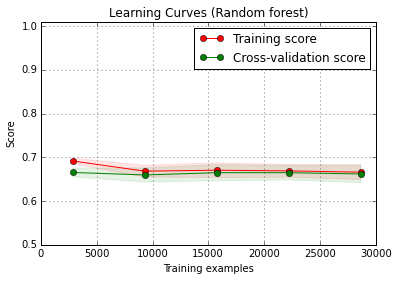

In [641]:

#X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.4, random_state=0)

title = "Learning Curves (Random forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = cross_validation.ShuffleSplit(x.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)

estimator = RandomForestClassifier(max_depth=5, n_estimators=50, max_features='auto', class_weight='auto') 
#SVC(kernel='linear') 
plot_learning_curve(estimator, title, x, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)

In [637]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


# MAIN

In [634]:
def main(argv):
    AlgorithmID = 2;
    noOfTopics = 10;
    url = "";
    if len(sys.argv) < 2:
        print "Input:<program name> url (optional:AlgorithmID noOfTopics)"
        print "AlgorithmID: 1 = RAkE"
        print "             2 = Supervised Learning Model"
        print "             3 = Text Rank"
    else:
        url = sys.argv[0]
        if len(sys.argv) == 2 :   
            AlgorithmID = sys.argv[1]
        if len(sys.argv) == 3 :   
            AlgorithmID = sys.argv[1]
            noOfTopics = sys.argv[2]
            
    #extract meaningful content from html file
    title, text = extract_text_html(url)
    allText = title + "\n" + text
    #get candidate words
    stop_words_path = "SmartStoplist.txt"
    stop_words_pattern = build_stop_word_regex(stop_words_path)
    sentence_list = split_sentences(text)
    phrase_list = generate_candidate_keywords(sentence_list, stop_words_pattern)
    #get candidate words from title
    sentence_list = split_sentences(title)
    phrase_list_title = generate_candidate_keywords(sentence_list, stop_words_pattern)
    phrase_list = phrase_list + phrase_list_title

    if AlgorithmID == 1:
        #1. run RAKE algorithm
        print "Running algorithm RAKE"
        rake = Rake()
        keywords = rake.run(phrase_list)
        for (elem,prob) in keywords[:noOfTopics]:
            print elem 
            
    elif AlgorithmID == 3:
        #2. run TextRank algorithm
        print "Running algorithm TextRank"
        textRank = TextRank()
        keywords = textRank.run(allText)

        for (elem,prob) in keywords[:noOfTopics]:
            print elem
    
    elif AlgorithmID == 2:
        print "Running algorithm Supervised Model"
        FEATURESFILE = "features.csv"
        sm = SupervisedModel(FEATURESFILE)
        keywords = sm.run(phrase_list, allText)
        for elem in keywords[:noOfTopics]:
            print elem
        

In [643]:
if __name__ == "__main__":
    try:
        sys.argv[0] = "http://www.cnn.com/2013/06/10/politics/edward-snowden-profile"

        sys.argv[1] = 1
        sys.argv[2] = 10
        main(sys.argv)
    except:
        print "Unexpected error:", sys.exc_info()[0]
        raise

Running algorithm RAKE
president barack obama
secrets wide open
overactive mother teresa
cell phone calls
track cell phone
global speculation sunday
mother teresa gene
high school diploma
ultimate destination unknown
barack obama insists
